In [1]:
import numpy as np
import qutip as qt
import xarray as xr
from dask.diagnostics import ProgressBar

from simulation_tutorial import xarray_mods as xrmod

Loosly based on https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/time-evolution/003_qubit-dynamics.ipynb

In [ ]:
def ramsey(time_array_s, detuning_hz=0):
    # hamiltonian
    H = detuning_hz * 2 * np.pi * qt.sigmaz() / 2.0
    # initial state
    psi0 = 1 / np.sqrt(2) * (qt.basis(2, 0) + qt.basis(2, 1))
    res = qt.mesolve(H, psi0, time_array_s, e_ops=[qt.sigmax()])
    return res.expect[0]

In [ ]:
ds = xr.Dataset()
ds["time"] = np.linspace(0, 2e-6, 100)
ds["detuning"] = np.random.normal(0, 0.5e6, 10000)
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time,
    ds.detuning,
    input_core_dims=[["time"], []],
    output_core_dims=[["time"]],
    vectorize=True,
    multiprocessing=True,
    chunksize=200,
)
ds

100%|██████████| 10000/10000 [00:11<00:00, 894.86it/s]


<xarray.Dataset> Size: 8MB
Dimensions:   (time: 100, detuning: 10000)
Coordinates:
  * time      (time) float64 800B 0.0 2.02e-08 4.04e-08 ... 1.98e-06 2e-06
  * detuning  (detuning) float64 80kB -5.157e+05 -2.122e+04 ... -3.059e+05
Data variables:
    sx        (detuning, time) float64 8MB 1.0 0.9979 0.9914 ... -0.4354 -0.4539

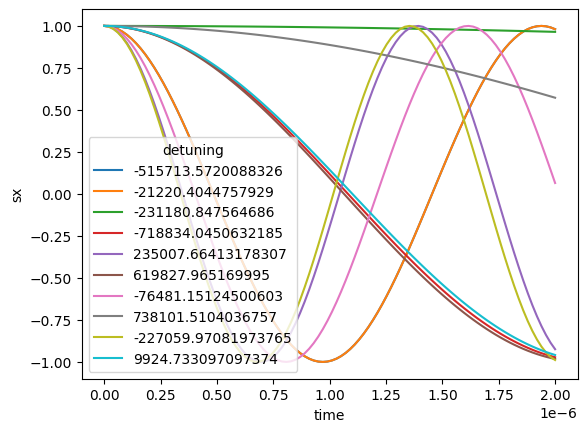

In [6]:
ds.isel(detuning=slice(0, 10)).sx.plot(hue="detuning");

In [8]:
ds["sx_exp"] = ds.sx.mean("detuning")

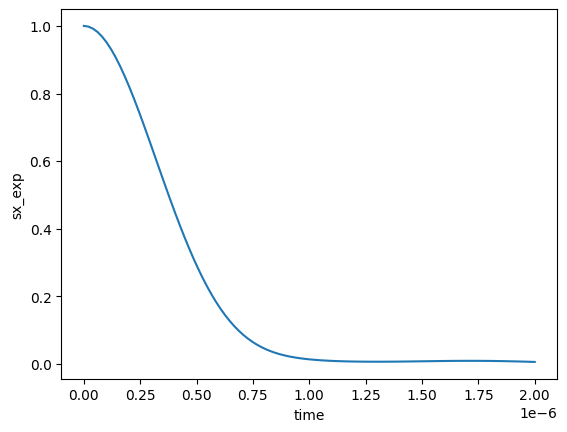

In [9]:
ds.sx_exp.plot()

# Double sweep

In [12]:
ds = xr.Dataset()
ds["time"] = np.linspace(0, 2e-6, 100)
ds["sigma"] = np.arange(0.2e6, 0.82e6, 0.1e6)
ds["detuning"] = xr.apply_ufunc(
    np.random.normal, 0, ds.sigma, 100, vectorize=True, output_core_dims=[["detuning"]]
)
ds["sx"] = xrmod.apply_ufunc(
    ramsey,
    ds.time,
    ds.detuning,
    input_core_dims=[["time"], []],
    output_core_dims=[["time"]],
    vectorize=True,
    multiprocessing=True,
    chunksize=200,
)
ds["sx_exp"] = ds.sx.mean("detuning")
ds

100%|██████████| 700/700 [00:00<00:00, 797.72it/s]


<xarray.Dataset> Size: 572kB
Dimensions:   (time: 100, sigma: 7, detuning: 100)
Coordinates:
  * time      (time) float64 800B 0.0 2.02e-08 4.04e-08 ... 1.98e-06 2e-06
  * sigma     (sigma) float64 56B 2e+05 3e+05 4e+05 5e+05 6e+05 7e+05 8e+05
    detuning  (sigma, detuning) float64 6kB -9.82e+04 2.375e+05 ... -5.462e+05
Data variables:
    sx        (sigma, detuning, time) float64 560kB 1.0 0.9999 ... 0.8391 0.8359
    sx_exp    (sigma, time) float64 6kB 1.0 0.9996 0.9985 ... 0.06223 0.05765

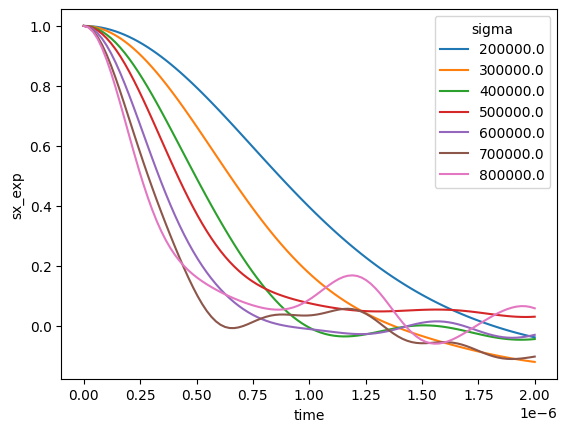

In [14]:
ds.sx_exp.plot(hue="sigma")